In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
import mriomain

ModuleNotFoundError: No module named 'mriomain'

In [11]:
input_mrio = '../data/mrio.parquet'
input_ee = '../data/ee.parquet'
mapping = pd.read_excel('../data/raw/countries.xlsx')

years = [2017, 2018, 2019, 2020, 2021]

## Industrial Sectors

**Objectives**

1. Defining emission intensive and trade exposed sectors
2. Quantifying carbon leakage risk


#### A. Emission Intensity
Volume of a country-sector's GHG emissions (direct + indirect) / country-sector's GVA
* *Direct emissions* - from a country-sector's production
* *Indirect emissions* - from the production of a country-sector's inputs

Notes:
- GO for denominator or different terms
- Composition of total ei by sector
- "Impact Ratio: Direct vs Indirect Cost"

In [12]:
df = duckdb.sql(f"SELECT * FROM '{input_ee}' LIMIT 5").df()
labels = df.columns[4:2559].to_frame(index=False)[0].str.split("_", expand=True)
labels = labels.set_axis(['country', 'sector'], axis=1)

In [13]:
dfs = []
for year in years: 
    data_ee = mriomain.EE(f'{input_ee}', year)
    data_mrio = mriomain.MRIO(f'{input_mrio}', year, full=True)

    # direct emissions
    direct = data_ee.E

    # indirect emissions
    e = data_ee.E @ (1/data_mrio.x).diag()
    B = data_mrio.B
    Z = data_mrio.Z
    indirect = (e @ B) @ Z

    # total emissions
    total = direct + indirect
    total = np.array(total.data.tolist()[0])   

    # emission intensity
    gva = data_mrio.va
    gva = np.array(gva.data.tolist())

    d_ei = np.array(direct.data.tolist()[0]) / gva
    i_ei = np.array(indirect.data.tolist()[0]) / gva
    ei = total / gva

    emissions_dict = {
        'year': year,
        'direct': direct.data.tolist()[0],
        'indirect': indirect.data.tolist()[0],
        'total': total.tolist(),
        'gva': gva.tolist(),
        'd_ei': d_ei.tolist(),
        'i_ei': i_ei.tolist(),
        'ei': ei.tolist()
    }

    year_df = pd.concat([labels, pd.DataFrame.from_dict(emissions_dict)], axis=1)
    dfs.append(year_df)
    
em_df = pd.concat(dfs, ignore_index=True)

AttributeError: module 'mrio' has no attribute 'EE'

In [564]:
sectors = [f"c{i}" for i in range(6, 16+1)]
sectors_map = {
    'c6': 'Wood and products of wood and cork',
    'c7': 'Pulp, paper, paper products',
    'c8': 'Coke, refined petroleum, and nuclear fuel',
    'c9': 'Chemicals and chemical products',
    'c10': 'Rubber and plastics',
    'c11': 'Other nonmetallic minerals',
    'c12': 'Basic metals and fabricated metal',
    'c13': 'Machinery, nec',
    'c14': 'Electrical and optical equipment',
    'c15': 'Transport equipment',
    'c16': 'Manufacturing, nec; recycling'
}

industry_df = em_df[em_df['sector'].isin(sectors)].copy()
industry_df['sector_name'] = industry_df['sector'].map(sectors_map)
industry_df

,country,sector,year,direct,indirect,total,gva,d_ei,i_ei,ei,sector_name
5,AUS,c6,2017,1935.206125,7266.369181,9201.575306,2887.853870,0.670119,2.516183,3.186302,Wood and products of wood and cork
6,AUS,c7,2017,874.312397,10094.311674,10968.624071,9779.082025,0.089406,1.032235,1.121641,"Pulp, paper, paper products"
7,AUS,c8,2017,24160.665271,11982.498704,36143.163975,4551.511972,5.308272,2.632641,7.940914,"Coke, refined petroleum, and nuclear fuel"
8,AUS,c9,2017,9224.167860,7326.838694,16551.006554,6275.871857,1.469783,1.167461,2.637244,Chemicals and chemical products
9,AUS,c10,2017,569.602247,5527.060653,6096.662900,3686.041738,0.154530,1.499457,1.653986,Rubber and plastics
...,...,...,...,...,...,...,...,...,...,...,...
12751,RoW,c12,2021,208545.157337,757342.830801,965887.988139,100103.615793,2.083293,7.565589,9.648882,Basic metals and fabricated metal
12752,RoW,c13,2021,140295.097161,288618.417637,428913.514797,65000.693966,2.158363,4.440236,6.598599,"Machinery, nec"
12753,RoW,c14,2021,30892.706237,403904.066876,434796.773113,110459.669905,0.279674,3.656575,3.936249,Electrical and optical equipment
12754,RoW,c15,2021,3712.132791,291214.394617,294926.527408,80208.297088,0.046281,3.630727,3.677008,Transport equipment


In [565]:
industry_df[industry_df['d_ei'] == np.inf]

,country,sector,year,direct,indirect,total,gva,d_ei,i_ei,ei,sector_name
2282,ARM,c8,2017,16.161412,0.0,16.161412,0.0,inf,NaN,inf,"Coke, refined petroleum, and nuclear fuel"
4837,ARM,c8,2018,11.617429,0.0,11.617429,0.0,inf,NaN,inf,"Coke, refined petroleum, and nuclear fuel"
7392,ARM,c8,2019,8.429720,0.0,8.429720,0.0,inf,NaN,inf,"Coke, refined petroleum, and nuclear fuel"
9947,ARM,c8,2020,12.383702,0.0,12.383702,0.0,inf,NaN,inf,"Coke, refined petroleum, and nuclear fuel"
12502,ARM,c8,2021,12.383702,0.0,12.383702,0.0,inf,NaN,inf,"Coke, refined petroleum, and nuclear fuel"


In [566]:
region = mapping.iloc[:, [8,12]]
industry_df = pd.merge(industry_df, region, left_on='country', right_on='code')

##### I. EI of industrial sectors by country (scatter)

In [493]:
ei_agg = (
    industry_df[['country', 'year', 'direct', 'indirect', 'total', 'gva', 'region']]
    .groupby(['country', 'year', 'region']).agg('sum')
    .reset_index()
)
ei_agg['d_ei'] = ei_agg['direct'] / ei_agg['gva']
ei_agg['i_ei'] = ei_agg['indirect'] / ei_agg['gva']
ei_agg['ei'] = ei_agg['total'] / ei_agg['gva']

In [494]:
ei_2021 = ei_agg[ei_agg['year'] == 2021]

In [495]:
# chart settings
plt.rcParams['font.family'] = 'Arial'

region_colors = {
    'Latin America and the Caribbean': '#e9532b',
    'Europe and Central Asia': '#8dc63f',
    'East Asia and Pacific': '#007db7',
    'South Asia': '#6dcff6',
    'North America': '#f57f29',
    'Middle East and North Africa': '#f2e600'
}
mapped_colors = [region_colors[region] for region in ei_2021.region]

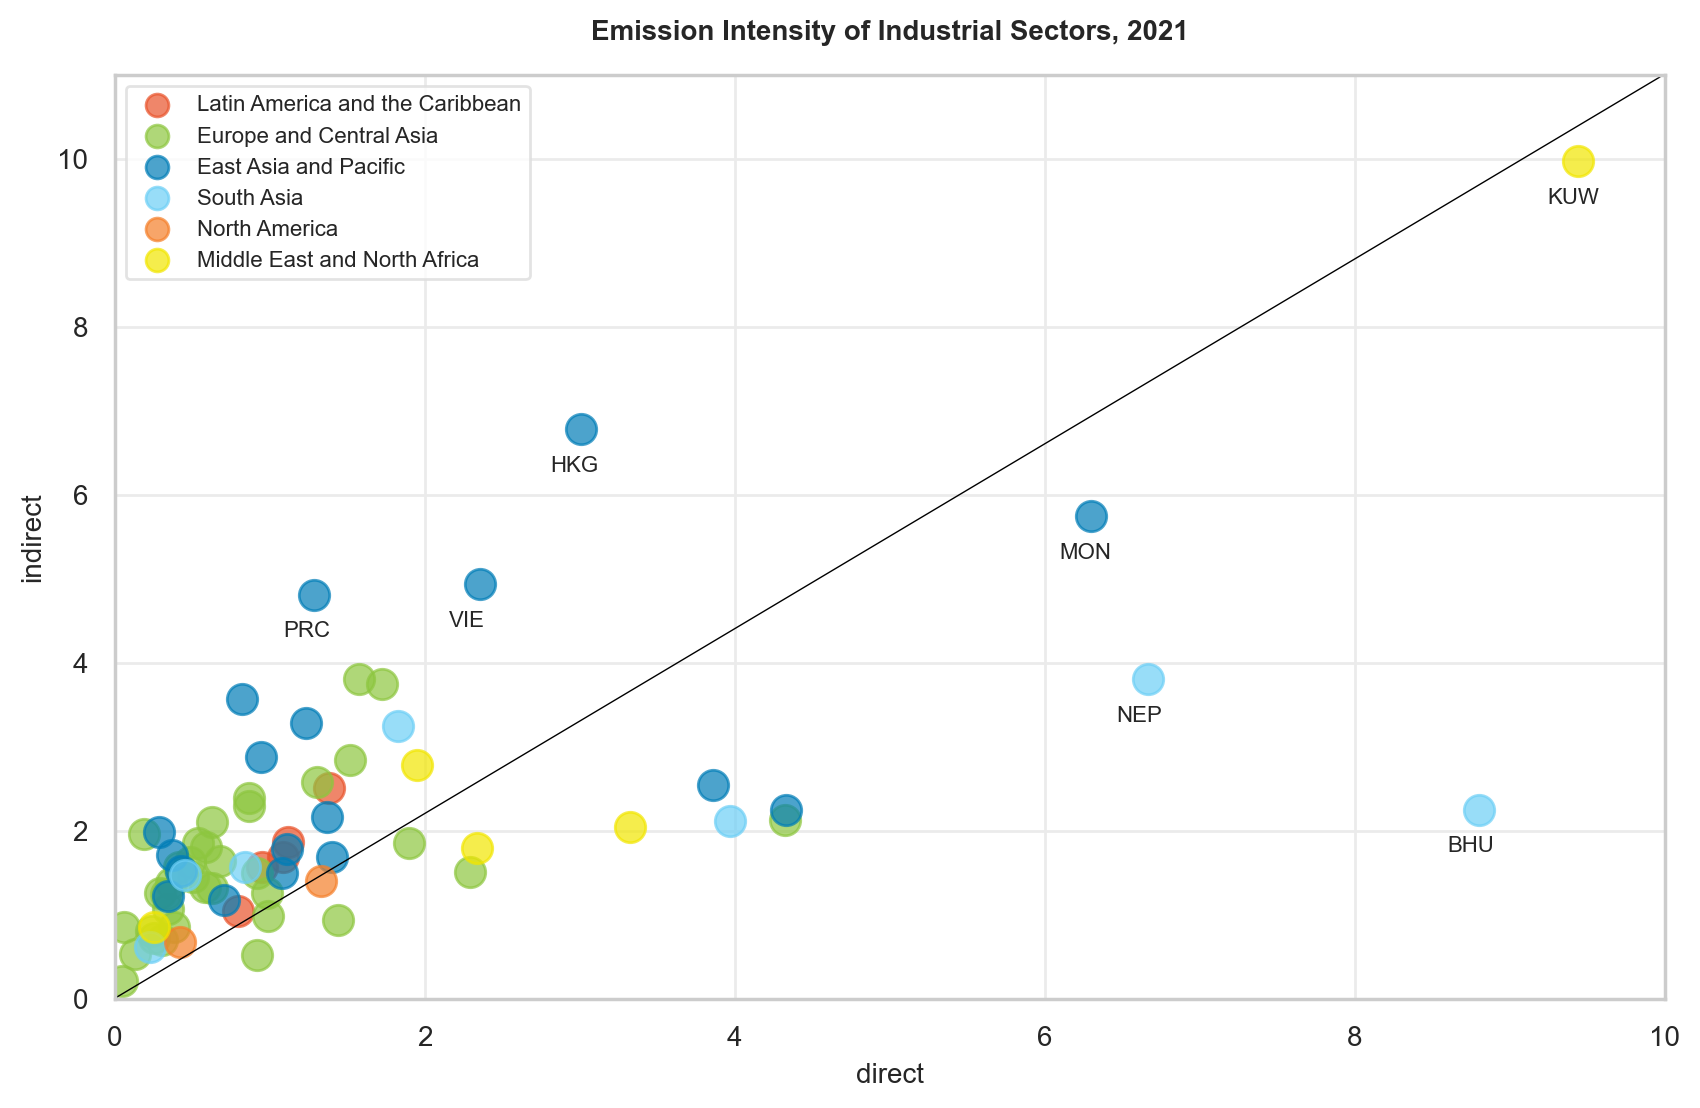

In [496]:
plt.figure(figsize=(10, 6), dpi=200, edgecolor='#EBEBEB')
plt.plot([0, ei_2021['i_ei'].max()], [0, ei_2021['i_ei'].max()+1], color='black', linewidth=0.5)
for region, color in region_colors.items():
    region_data = ei_2021[ei_2021['region'] == region]
    plt.scatter(x=region_data['d_ei'], y=region_data['i_ei'], c=color, s=120, alpha=0.7, label=region)

for i, (x, y) in enumerate(zip(ei_2021.d_ei, ei_2021.i_ei)):
    if x > 6 or y > 4:
        plt.annotate(ei_2021.country.iloc[i], (x-0.2, y - 0.5), fontsize=8)

plt.grid(color='#EBEBEB') 
plt.xlim((0,10))
plt.ylim((0,11))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('direct', fontsize=10)
plt.ylabel('indirect', fontsize=10)
plt.title('Emission Intensity of Industrial Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75)
legend.get_frame().set_edgecolor('#DDDDDD')
plt.show()

##### II. EI of industrial sectors by country (bar)

In [240]:
ei_asia = ei_2021[ei_2021['region'].isin(['East Asia and Pacific', 'Europe and Central Asia', 'South Asia'])]

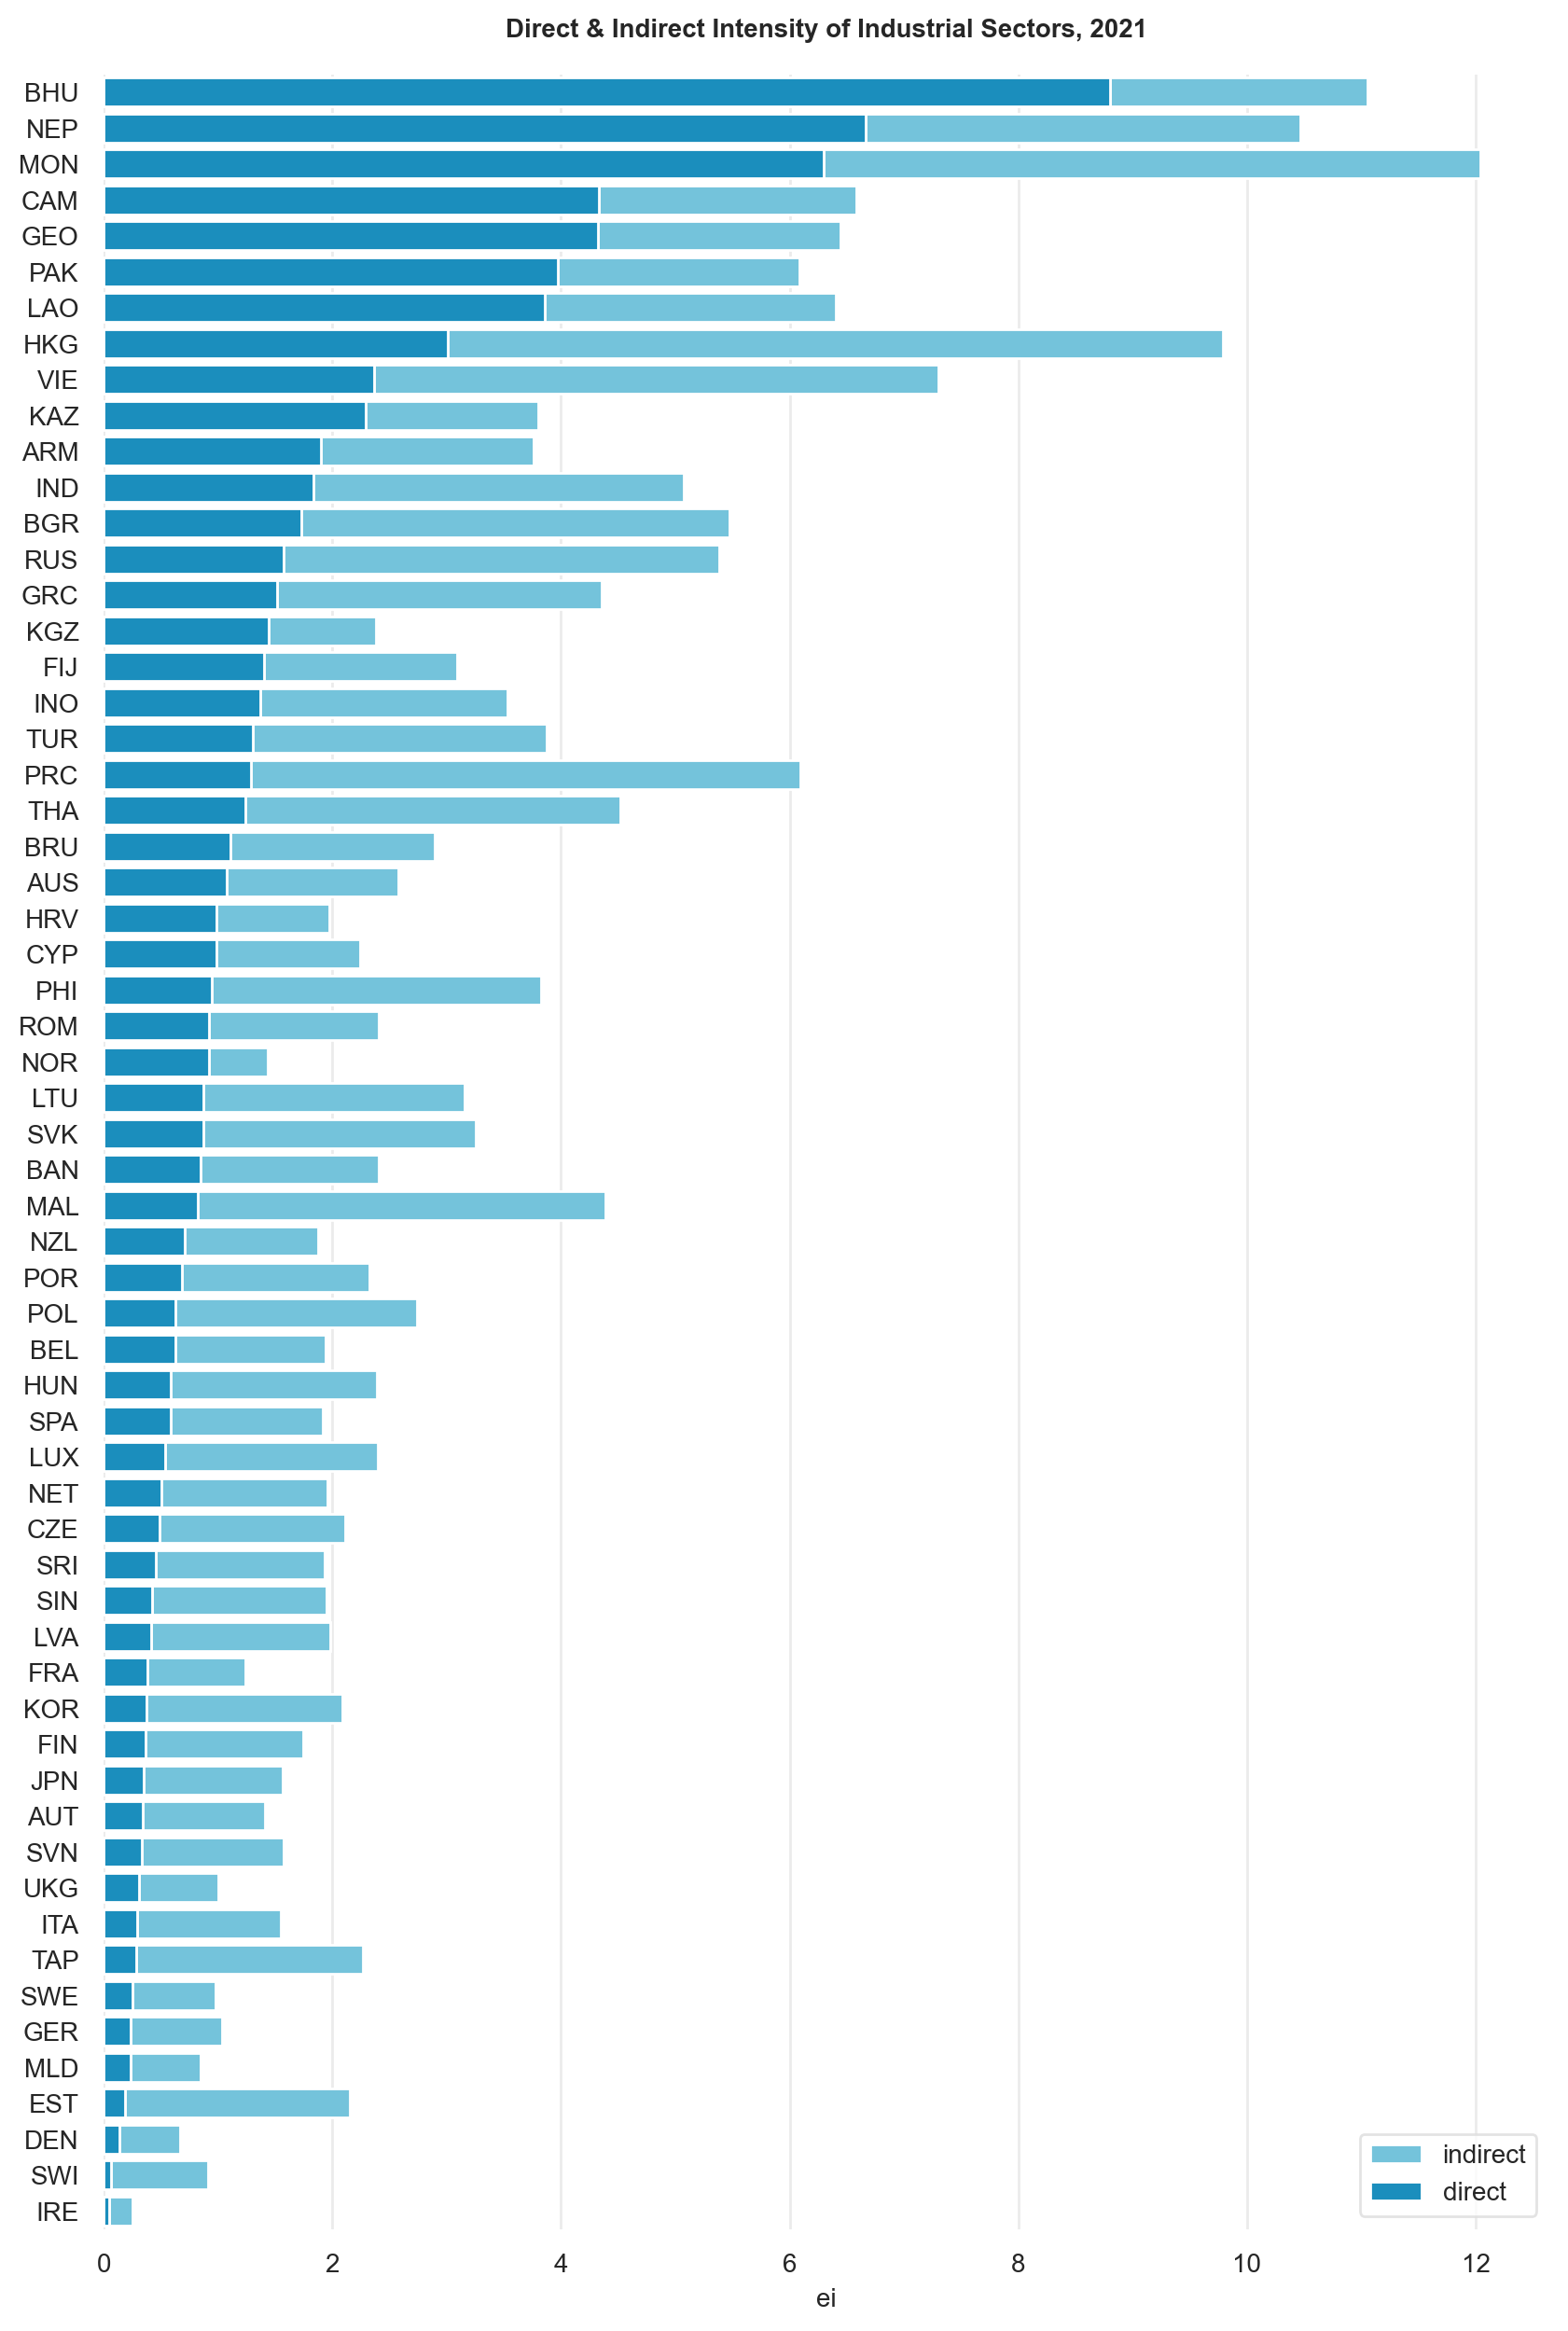

In [532]:
ordered_df = ei_asia.sort_values(by='d_ei', ascending=False)
left_positions = ordered_df["d_ei"].values

f, ax = plt.subplots(figsize=(10, 15), dpi=200)
sns.barplot(x="i_ei", y="country", data=ordered_df, label="indirect", 
            color="#63ccec", errorbar=None, left=left_positions)
sns.barplot(x="d_ei", y="country", data=ordered_df,
            label="direct", color="#0099d8", errorbar=None)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('ei', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Intensity of Industrial Sectors, 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
sns.despine(left=True, bottom=True)

##### III. EI of industrial sectors, 2017 vs 2021

In [717]:
ei_total = ei_agg[['country', 'year', 'region', 'd_ei', 'i_ei', 'ei']]
ei_total = ei_total[(ei_total['year'].isin([2017, 2021])) & 
                    (ei_total['region'] == 'East Asia and Pacific')]
ei_total = ei_total.pivot(index=['country', 'region'], columns='year', values='ei').reset_index()

Note: 
* Add 2019/2020

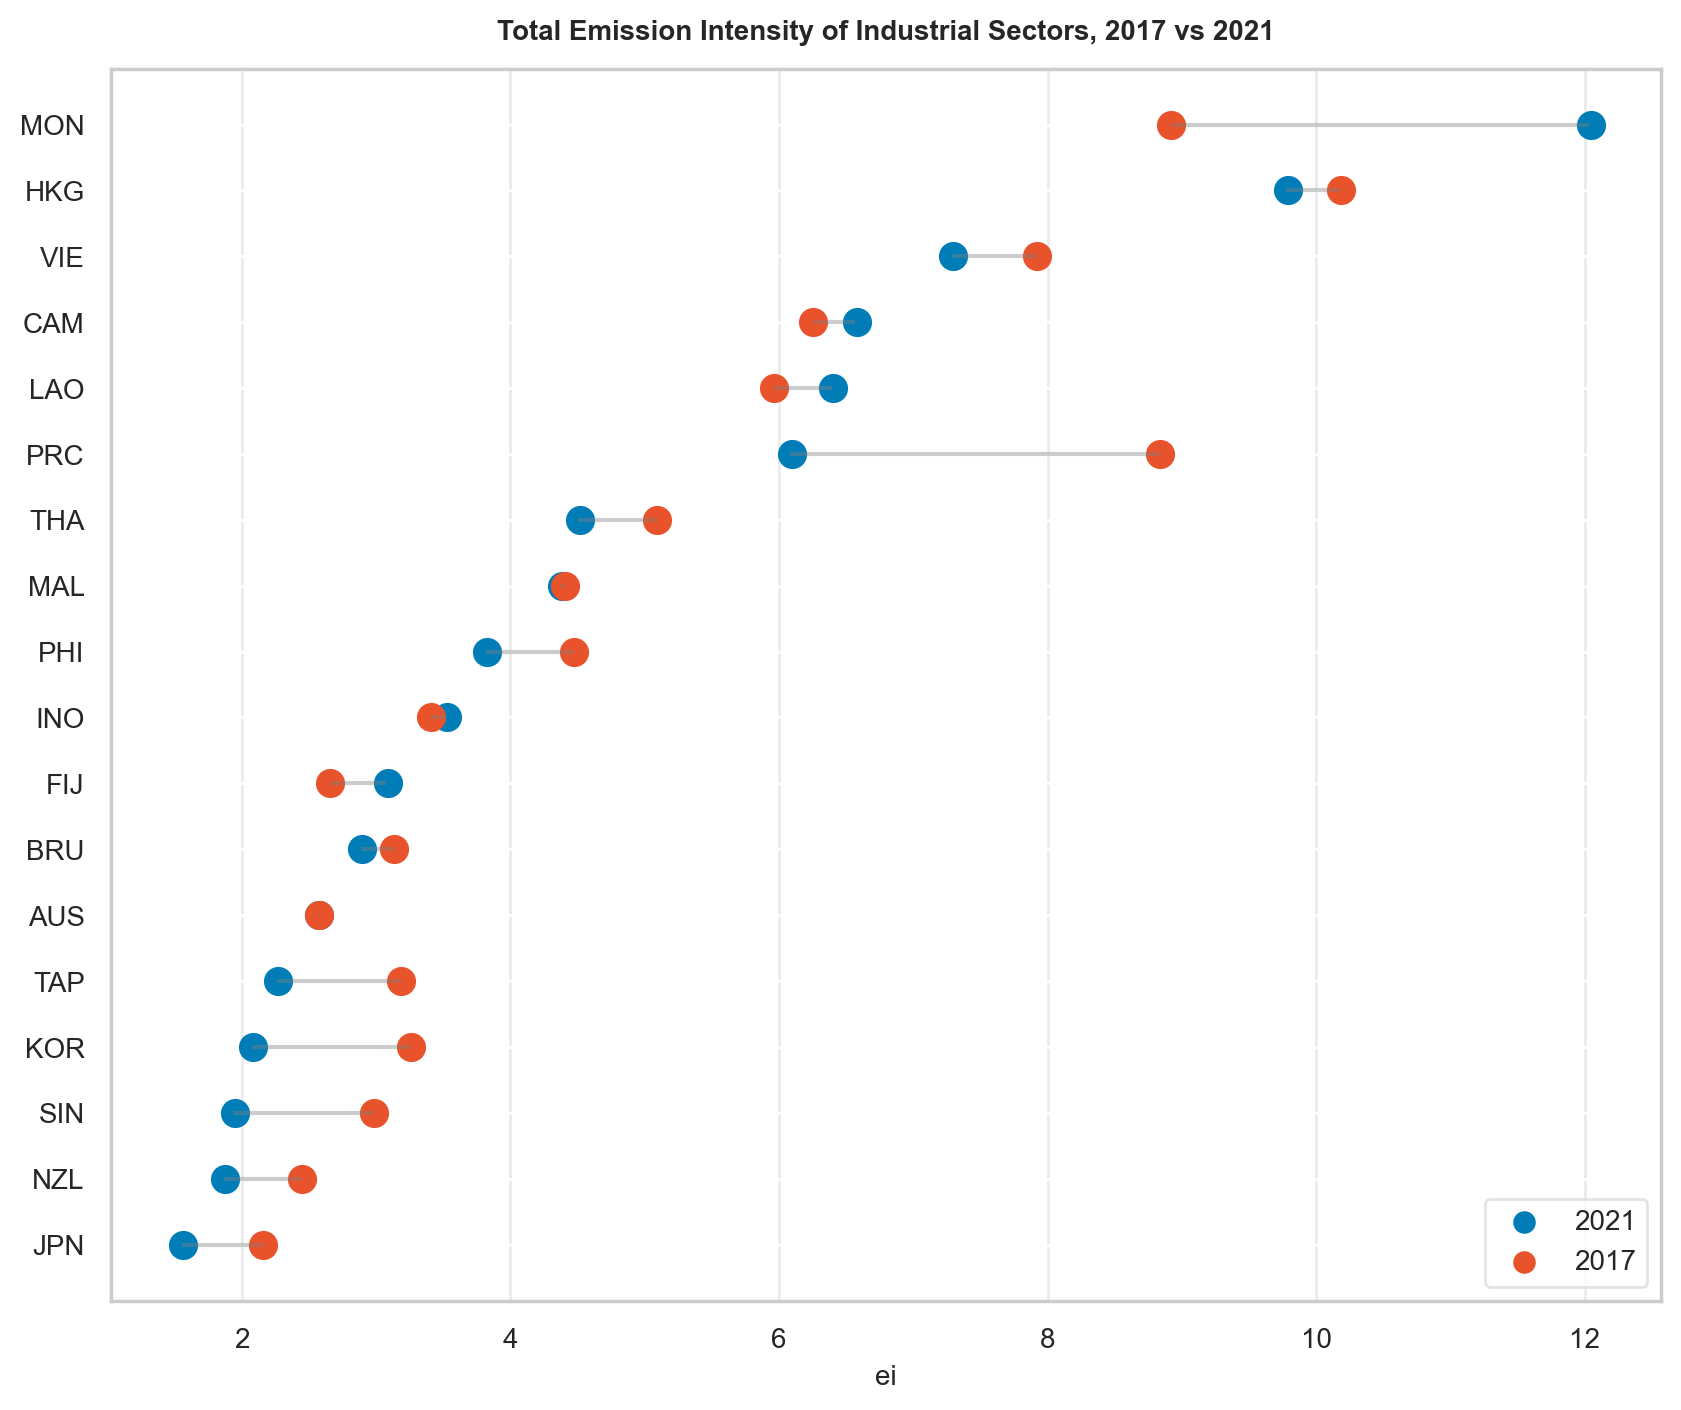

In [768]:
ordered_df = ei_total.sort_values(by=2021)

plt.figure(figsize=(10, 8), dpi=200, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2021], y=ordered_df['country'], color='#007db7', alpha=1, label='2021', s=90)
plt.scatter(x=ordered_df[2017], y=ordered_df['country'], color='#e9532b', alpha=1, label='2017', s=90)
plt.hlines(y=ordered_df['country'], xmin=ordered_df[2017], xmax=ordered_df[2021]-0.01, color='grey', alpha=0.4)

plt.grid(axis='x', color='#EBEBEB') 
plt.grid(axis='y', color='white') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('ei', fontsize=10, y=-1.01)
plt.ylabel('')
plt.title('Total Emission Intensity of Industrial Sectors, 2017 vs 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.show()

##### IV. EI by sector

* Check specific examples of machinery, nec
* Breakdown by source of emission (energy, IPPU)

In [567]:
ei_sector = industry_df[industry_df['gva'] >0]
ei_sector = (
    ei_sector[['sector', 'sector_name', 'year', 'd_ei', 'i_ei', 'ei']]
    .groupby(['sector', 'sector_name', 'year']).agg('mean').reset_index()
    )

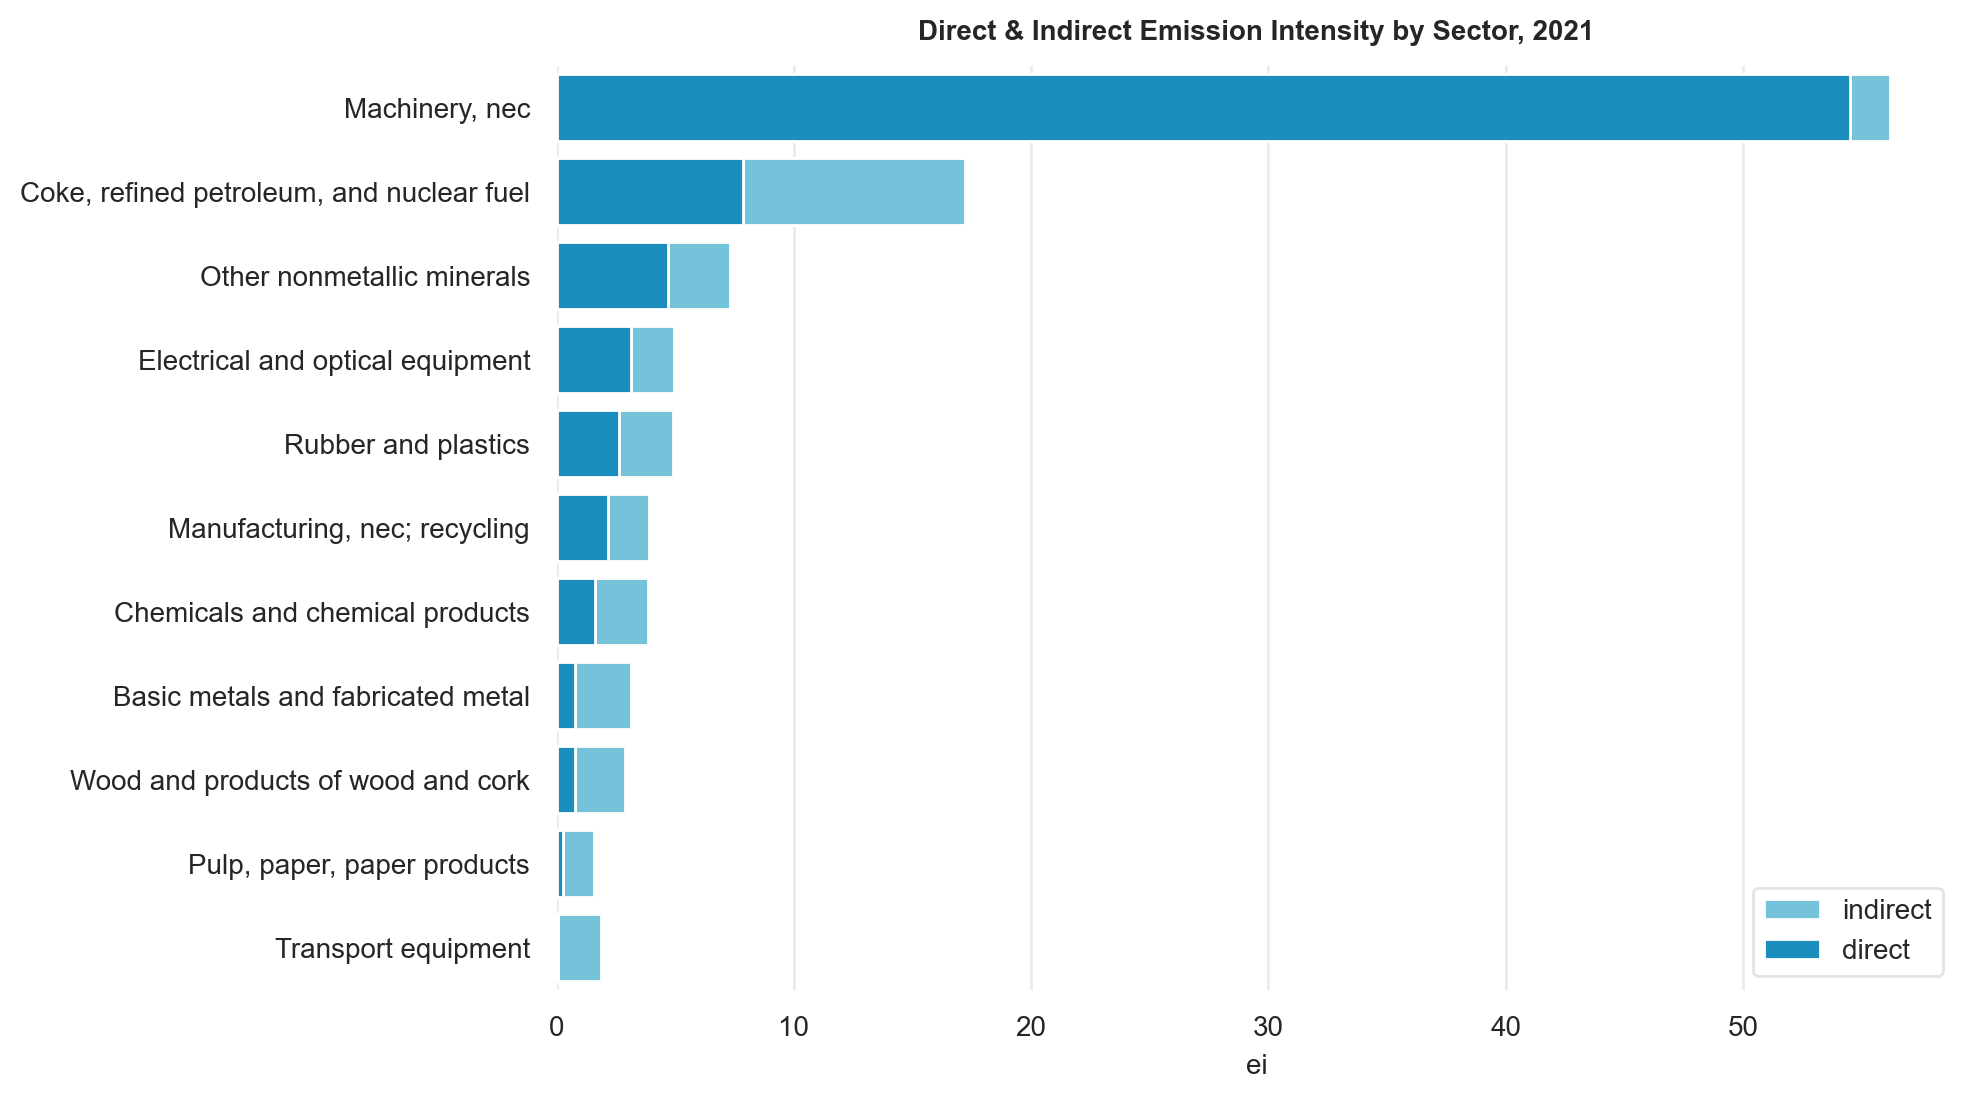

In [577]:
ordered_df = (
    ei_sector[(ei_sector['year'] == 2021)]
    .sort_values(by='d_ei', ascending=False)
)
left_positions = ordered_df["d_ei"].values

f, ax = plt.subplots(figsize=(10, 6), dpi=200)
sns.barplot(x="i_ei", y="sector", data=ordered_df, label="indirect", 
            color="#63ccec", errorbar=None, left=left_positions)
sns.barplot(x="d_ei", y="sector", data=ordered_df,
            label="direct", color="#0099d8", errorbar=None)

tick_labels = [sectors_map[sector] for sector in ordered_df['sector']]
ax.set_yticks(np.arange(len(ordered_df)))
ax.set_yticklabels(tick_labels)
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('ei', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Emission Intensity by Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
sns.despine(left=True, bottom=True)

##### V. 

Note: 
- Add additional year 2019/2020 in between

In [569]:
ei_sec_total = ei_sector[['sector', 'sector_name', 'year', 'ei']]
ei_sec_total = ei_sec_total[(ei_sec_total['year'].isin([2017, 2021]))]
ei_sec_total = ei_sec_total.pivot(index=['sector', 'sector_name'], columns='year', values='ei').reset_index()

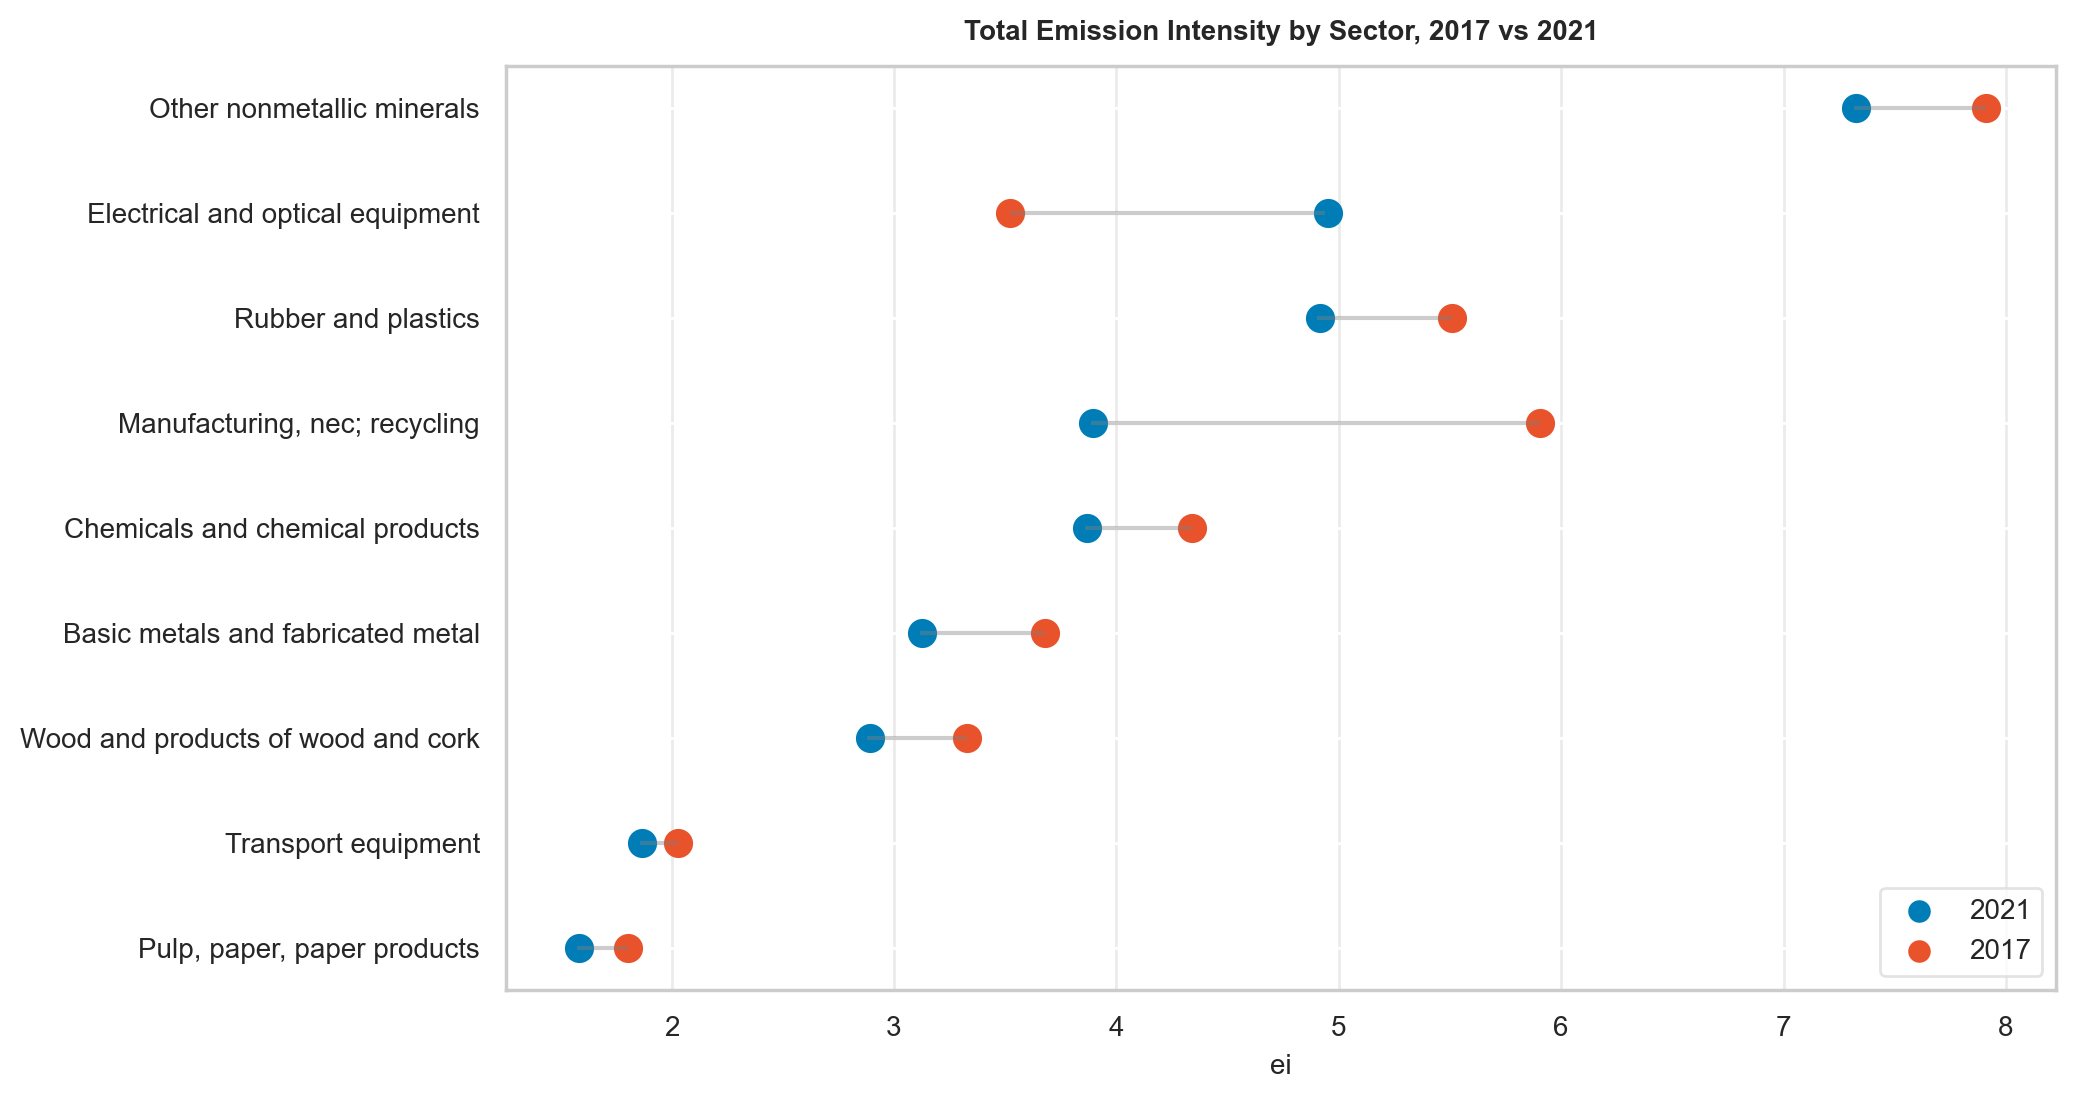

In [578]:
ordered_df = (ei_sec_total.sort_values(by=2021))
ordered_df = ordered_df[~ordered_df['sector'].isin(['c8', 'c13'])]

plt.figure(figsize=(10, 6), dpi=200, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2021], y=ordered_df['sector_name'], color='#007db7', alpha=1, label='2021', s=90)
plt.scatter(x=ordered_df[2017], y=ordered_df['sector_name'], color='#e9532b', alpha=1, label='2017', s=90)
plt.hlines(y=ordered_df['sector_name'], xmin=ordered_df[2017], xmax=ordered_df[2021]-0.01, color='grey', alpha=0.4)

plt.grid(axis='x', color='#EBEBEB') 
plt.grid(axis='y', color='white') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('ei', fontsize=10, y=-1.01)
plt.ylabel('')
plt.title('Total Emission Intensity by Sector, 2017 vs 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.show()

#### B. Trade Exposure
Value of international trade (imports + exports) / value of domestic market (domestic production + imports)

Notes:
* 

In [734]:
mrio_full = duckdb.sql(f"SELECT * FROM '{input_mrio}' where t = 2017").df()
mrio_full[['country', 'sector']] = mrio_full['si'].str.split('_', expand=True)
mrio_full = mrio_full.iloc[:-7]

# trade 
trade_df = mrio_full.copy()
for index, row in trade_df.iterrows():
    country_code = str(row['country'])
    for col in trade_df.columns:
        if col.startswith(country_code):
            trade_df.loc[index, col] = 0

# domestic (total output)
dom = mrio_full['ToT'].to_frame(name='dom')


In [745]:
imports = trade_df.drop(columns=['t', 'si', 'country', 'sector'])
imports = imports.sum().to_frame(name='imports').reset_index()
imports = imports[imports['index'] != 'ToT']

exports = trade_df.drop(columns=['t', 'si', 'country', 'sector']).sum(axis=1)
exports = exports.to_frame(name='exports')
exports = pd.concat([trade_df[['country', 'sector']], exports], axis=1)

trade = pd.concat([exports, imports.loc[:2554].drop(columns=['index'])], axis=1)
trade['trade'] = trade['exports'] + trade['imports']

# te_df
te_df = pd.concat([trade, dom], axis=1)
te_df['te'] = te_df['trade'] / te_df['dom']

In [747]:
te_df

,country,sector,exports,imports,trade,dom,te
0,AUS,c1,89704.248691,4759.960511,94464.209202,76590.551093,1.233366
1,AUS,c2,387101.069376,18841.703741,405942.773117,219904.607558,1.845995
2,AUS,c3,86044.224447,3506.908237,89551.132684,68876.130878,1.300177
3,AUS,c4,4988.766595,518.823014,5507.589610,3577.508549,1.539504
4,AUS,c5,1235.054228,160.027403,1395.081632,830.406474,1.679999
...,...,...,...,...,...,...,...
2550,RoW,c31,513650.840301,102654.196518,616305.036820,492217.433553,1.252099
2551,RoW,c32,384090.205187,65827.517658,449917.722845,368513.732064,1.220898
2552,RoW,c33,304381.041357,51282.237086,355663.278442,285723.423473,1.244782
2553,RoW,c34,352354.060559,53970.541167,406324.601726,312530.333504,1.300113


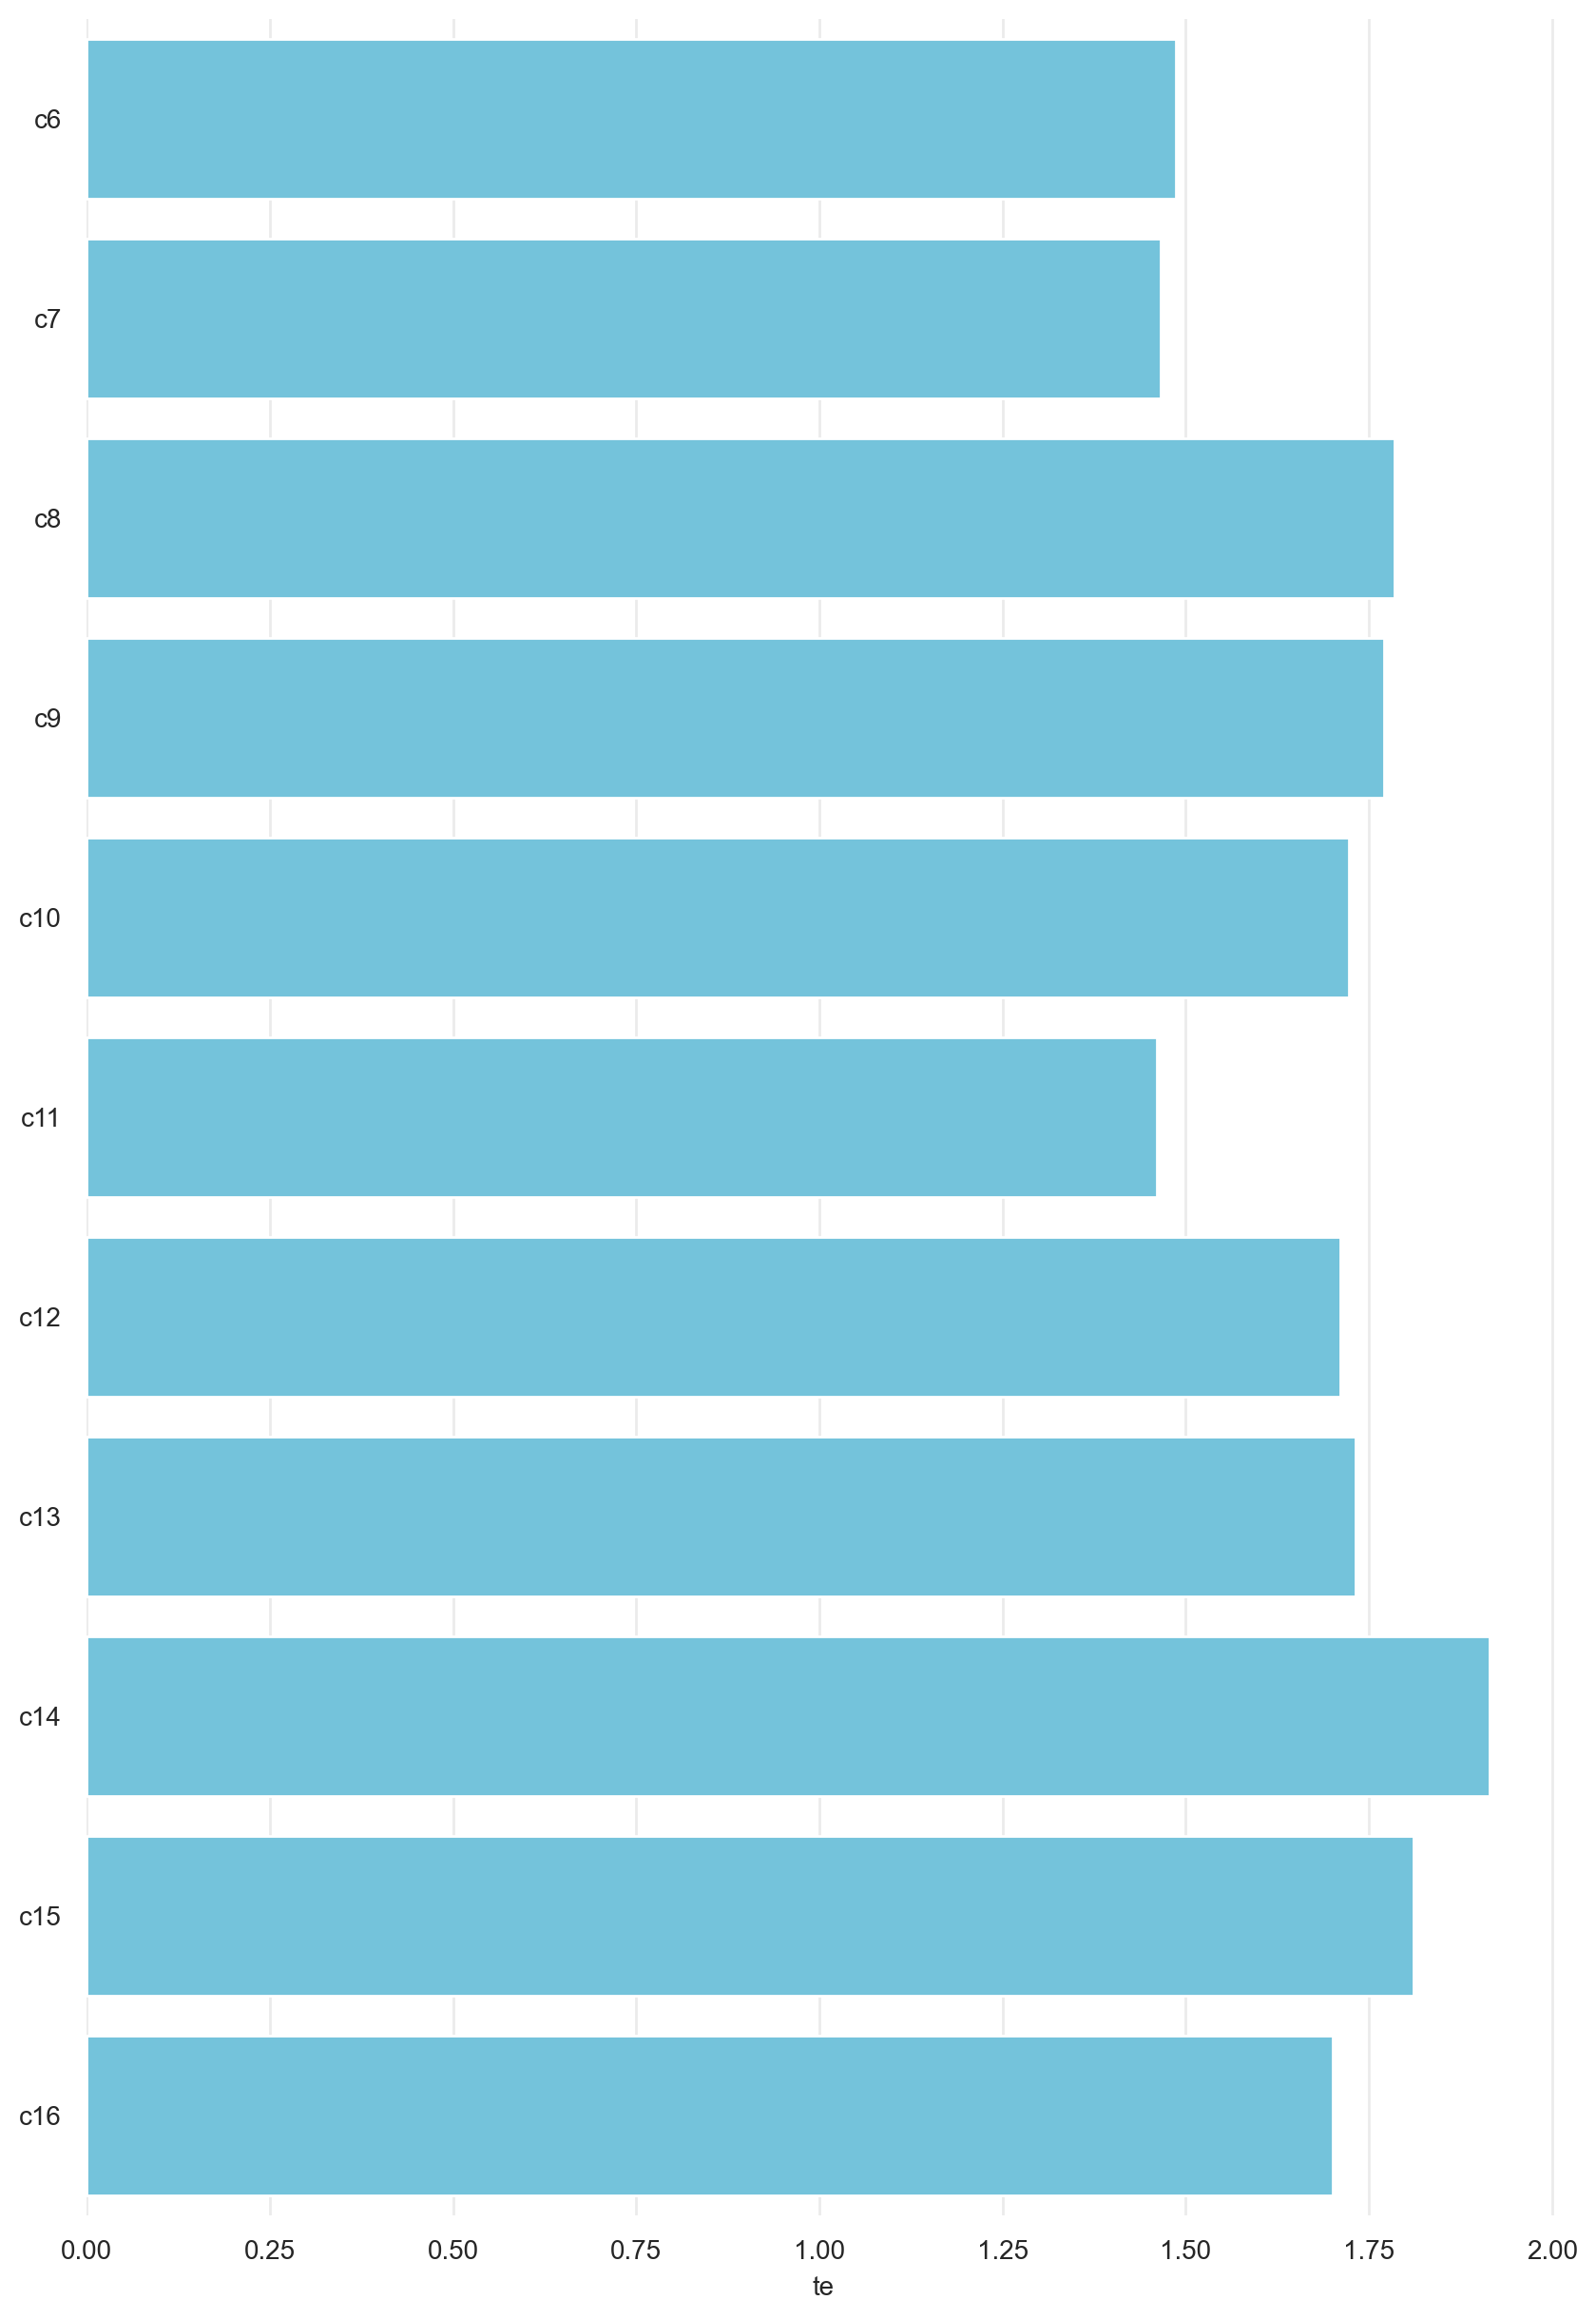

In [767]:
ordered_df = (
    te_df[te_df['sector'].isin(sectors)]
    .dropna(subset=['te']))

f, ax = plt.subplots(figsize=(10, 15), dpi=200)
sns.barplot(x="te", y="sector", data=ordered_df, 
            color="#63ccec", errorbar=None)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('te', fontsize=10)
plt.ylabel('')
sns.despine(left=True, bottom=True)

#### C. EITE

GDR 2023 
- Chapter (Bo Meng): carbon leakage measurement
- Similar to COVID analysis 
- Emissions (aut) vs emissions (act)